In [1]:
from typing import TypedDict, List, Dict, Literal, Union, Any, Annotated
from pydantic import BaseModel
from IPython.display import Image, display
import os
import getpass
import yaml
import json

from langchain_core.messages import AnyMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import MessagesState, StateGraph, add_messages, START, END
from langgraph.constants import Send
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.pregel import RetryPolicy

In [2]:
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = "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"

In [3]:
tavily_search = TavilySearchResults(max_results=3)

def web_search(query: str) -> List[Dict]:
    """
    Perform a web search for the given query string and return a list of three search results.

    Args:
        query (str): The search query to look up.

    Returns:
        List[Dict]: A list of 3 dictionaries, each representing a single search result.
    """
    print("Doing a web search for", query)
    return tavily_search.invoke(query)

web_search("What's the most popular song right now?")

/var/folders/hk/38612x253n1dsh0hrzz8lk9c0000gn/T/ipykernel_91518/894478212.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


Doing a web search for What's the most popular song right now?


[{'title': 'Billboard Hot 100 - Official Charts',
  'url': 'https://www.officialcharts.com/charts/billboard-hot-100-chart/',
  'content': "Read more icon%20Copyright%202023%20Fonticons,%20Inc.%20--%3e%3cpath%20d='M256%2048a208%20208%200%201%201%200%20416%20208%20208%200%201%201%200-416zm0%20464A256%20256%200%201%200%20256%200a256%20256%200%201%200%200%20512zM216%20336c-13.3%200-24%2010.7-24%2024s10.7%2024%2024%2024h80c13.3%200%2024-10.7%2024-24s-10.7-24-24-24h-8V248c0-13.3-10.7-24-24-24H216c-13.3%200-24%2010.7-24%2024s10.7%2024%2024%2024h24v64H216zm40-144a32%2032%200%201%200%200-64%2032%2032%200%201%200%200%2064z'/%3e%3c/svg%3e) [...] Read more icon%20Copyright%202023%20Fonticons,%20Inc.%20--%3e%3cpath%20d='M256%2048a208%20208%200%201%201%200%20416%20208%20208%200%201%201%200-416zm0%20464A256%20256%200%201%200%20256%200a256%20256%200%201%200%200%20512zM216%20336c-13.3%200-24%2010.7-24%2024s10.7%2024%2024%2024h80c13.3%200%2024-10.7%2024-24s-10.7-24-24-24h-8V248c0-13.3-10.7-24-24-24H216c

In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  # or any other Gemini model you want to use
    google_api_key=input("GEMINI_API_KEY"),  # replace with your actual API key
    temperature=0.7
)

response = llm.invoke("What is the capital of France?")
print(response.content)

The capital of France is **Paris**.


## DebateAgent

In [5]:
from typing import Annotated, List
from langgraph.graph.message import add_messages

def keep_left(left: Any, right: Any) -> Any:
    return left

def keep_right(left: Any, right: Any) -> Any:
    return right
    
class DebateState(TypedDict):
    """
    Represents the complete state of a debate session, tracking each stage and participant response.

    Attributes:
        issue (str): The main topic or question being debated.
        position_a (str): The stance or viewpoint of Debater A.
        position_b (str): The stance or viewpoint of Debater B.
        opening_a (str): Opening statement presented by Debater A.
        opening_b (str): Opening statement presented by Debater B.
        opening_judge_results (str): Judge's evaluation of the opening statements.
        rebuttal_a (str): Rebuttal argument from Debater A.
        rebuttal_b (str): Rebuttal argument from Debater B.
        rebuttal_judge_results (str): Judge's evaluation of the rebuttal round.
        closing_a (str): Closing statement from Debater A.
        closing_b (str): Closing statement from Debater B.
        closing_judge_results (str): Judge's evaluation of the closing statements.
        final_judge_results (str): Final overall evaluation and results provided by the judge.
    """
    messages_a: Annotated[List[str], add_messages]
    messages_b: Annotated[List[str], add_messages]

    issue: Annotated[str, keep_right]
    position_a: Annotated[str, keep_right]
    position_b: Annotated[str, keep_right]
    opening_a: Annotated[str, keep_right]
    opening_b: Annotated[str, keep_right]
    opening_judge_results: Annotated[str, keep_right]
    rebuttal_a: Annotated[str, keep_right]
    rebuttal_b: Annotated[str, keep_right]
    rebuttal_judge_results: Annotated[str, keep_right]
    closing_a: Annotated[str, keep_right]
    closing_b: Annotated[str, keep_right]
    final_judge_results: Annotated[str, keep_right]


In [6]:
def export_debate_state(state: DebateState, filename: str):
    with open(filename, "w") as f:
        f.write("=== Debate Export ===\n\n")
        f.write(f"Issue: {state["issue"]}\n\n")
        f.write("Positions:\n")
        f.write(f"  Position A: {state["position_a"]}\n")
        f.write(f"  Position B: {state["position_b"]}\n")
        f.write("-" * 80 + "\n\n")

        f.write("\nOpenings:\n")
        f.write(f"  Opening A: {state["opening_a"].content}\n\n")
        f.write(f"  Opening B: {state["opening_b"].content}\n\n")
        f.write(f"Opening Judge Results:\n")
        f.write(state["opening_judge_results"].content + "\n\n")
        f.write("-" * 80 + "\n\n")
        
        f.write("\nRebuttals:\n")
        f.write(f"  Rebuttal A: {state["rebuttal_a"].content}\n\n")
        f.write(f"  Rebuttal B: {state["rebuttal_b"].content}\n\n")
        f.write(f"Rebuttal Judge Results:\n")
        f.write(state["rebuttal_judge_results"].content + "\n\n")
        f.write("-" * 80 + "\n\n")

        f.write("\nClosings:\n")
        f.write(f"  Closing A: {state["closing_a"].content}\n\n")
        f.write(f"  Closing B: {state["closing_b"].content}\n\n")
        f.write("-" * 80 + "\n\n")
        
        f.write("\nFinal Judge Results:\n")
        f.write(state["final_judge_results"].content)
        f.write("\n====================\n")

In [7]:
llm_with_search = llm.bind_tools([web_search])

In [8]:
def debater_factory(side: Literal["a", "b"], prompt_name: str, prompt_input_map: Dict[str, str]):
    # TODO: I think you could also add another tool that allows the LLM to reason about previous tool call outputs
    def debater_llm(state: DebateState) -> DebateState:
        print(f"In debater_llm, side = {side}, prompt = {prompt_name}")
        with open("prompts.yaml", "r") as f:
            prompt_template = yaml.safe_load(f)[prompt_name]

        prompt_inputs = {key: state[value] for key, value in prompt_input_map.items()}
        prompt = prompt_template.format(**prompt_inputs)

        instruction = HumanMessage(content=prompt)
        result = llm_with_search.invoke([instruction])

        print(f"Result for side = {side}, prompt_name = {prompt_name} is {result}")

        return {
            f"messages_{side}": [result],
        }

    return debater_llm

debater_a_opening_llm = debater_factory(
    side="a",
    prompt_name="opening_statement",
    prompt_input_map={
        "issue": "issue",
        "position": "position_a",
        "messages": "messages_a"
    }
)

debater_b_opening_llm = debater_factory(
    side="b",
    prompt_name="opening_statement",
    prompt_input_map={
        "issue": "issue",
        "position": "position_b",
        "messages": "messages_b"
    }
)

debater_a_rebuttal_llm = debater_factory(
    side="a",
    prompt_name="rebuttal",
    prompt_input_map={
        "issue": "issue",
        "position": "position_a",
        "your_opening": "opening_a",
        "opponent_opening": "opening_b",
        "messages": "messages_a",
        "judge_comments": "opening_judge_results"
    }
)

debater_b_rebuttal_llm = debater_factory(
    side="b",
    prompt_name="rebuttal",
    prompt_input_map={
        "issue": "issue",
        "position": "position_b",
        "your_opening": "opening_b",
        "opponent_opening": "opening_a",
        "messages": "messages_b",
        "judge_comments": "opening_judge_results"
    }
)

debater_a_closing_llm = debater_factory(
    side="a",
    prompt_name="closing_statement",
    prompt_input_map={
        "issue": "issue",
        "position": "position_a",
        "opponent_position": "position_b",
        "your_opening": "opening_a",
        "opponent_opening": "opening_b",
        "your_rebuttal": "rebuttal_a",
        "opponent_rebuttal": "rebuttal_b",
        "your_messages": "messages_a"
    }
)

debater_b_closing_llm = debater_factory(
    side="b",
    prompt_name="closing_statement",
    prompt_input_map={
        "issue": "issue",
        "position": "position_b",
        "opponent_position": "position_a",
        "your_opening": "opening_b",
        "opponent_opening": "opening_a",
        "your_rebuttal": "rebuttal_b",
        "opponent_rebuttal": "rebuttal_a",
        "your_messages": "messages_b"
    }
)

In [9]:
def custom_tool_router_factory(side: Literal['a', 'b']):
    def custom_tool_router(
        state: Union[list[AnyMessage], dict[str, Any], BaseModel],
        messages_key: str = f"messages_{side}"
    ) -> Literal[f"debater_{side}_tools", '__end__']:
        if isinstance(state, list):
            ai_message = state[-1]
        elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
            ai_message = messages[-1]
        elif messages := getattr(state, messages_key, []):
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")
        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return f"debater_{side}_tools"
        return "__end__"
    
    return custom_tool_router

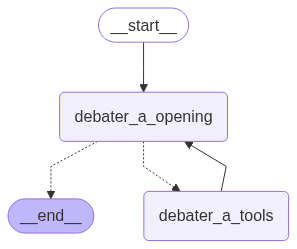

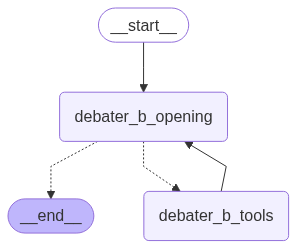

In [10]:
# Debater A Opening
debater_a_opening_subgraph_builder = StateGraph(DebateState)
debater_a_opening_subgraph_builder.add_node("debater_a_opening", debater_a_opening_llm, retry_policy=RetryPolicy())
debater_a_opening_subgraph_builder.add_node("debater_a_tools", ToolNode([web_search], messages_key="messages_a"))

debater_a_opening_subgraph_builder.add_edge(START, "debater_a_opening")
debater_a_opening_subgraph_builder.add_conditional_edges("debater_a_opening", custom_tool_router_factory(side="a"))
debater_a_opening_subgraph_builder.add_edge("debater_a_tools", "debater_a_opening")

# Debater A Rebuttal
debater_a_rebuttal_subgraph_builder = StateGraph(DebateState)
debater_a_rebuttal_subgraph_builder.add_node("debater_a_rebuttal", debater_a_rebuttal_llm, retry_policy=RetryPolicy())
debater_a_rebuttal_subgraph_builder.add_node("debater_a_tools", ToolNode([web_search], messages_key="messages_a"))

debater_a_rebuttal_subgraph_builder.add_edge(START, "debater_a_rebuttal")
debater_a_rebuttal_subgraph_builder.add_conditional_edges("debater_a_rebuttal", custom_tool_router_factory(side="a"))
debater_a_rebuttal_subgraph_builder.add_edge("debater_a_tools", "debater_a_rebuttal")

# Debater A Closing
debater_a_closing_subgraph_builder = StateGraph(DebateState)
debater_a_closing_subgraph_builder.add_node("debater_a_closing", debater_a_closing_llm, retry_policy=RetryPolicy())
debater_a_closing_subgraph_builder.add_node("debater_a_tools", ToolNode([web_search], messages_key="messages_a"))

debater_a_closing_subgraph_builder.add_edge(START, "debater_a_closing")
debater_a_closing_subgraph_builder.add_conditional_edges("debater_a_closing", custom_tool_router_factory(side="a"))
debater_a_closing_subgraph_builder.add_edge("debater_a_tools", "debater_a_closing")

# Debater B Opening
debater_b_opening_subgraph_builder = StateGraph(DebateState)
debater_b_opening_subgraph_builder.add_node("debater_b_opening", debater_b_opening_llm, retry_policy=RetryPolicy())
debater_b_opening_subgraph_builder.add_node("debater_b_tools", ToolNode([web_search], messages_key="messages_b"))

debater_b_opening_subgraph_builder.add_edge(START, "debater_b_opening")
debater_b_opening_subgraph_builder.add_conditional_edges("debater_b_opening", custom_tool_router_factory(side="b"))
debater_b_opening_subgraph_builder.add_edge("debater_b_tools", "debater_b_opening")

# Debater B Rebuttal
debater_b_rebuttal_subgraph_builder = StateGraph(DebateState)
debater_b_rebuttal_subgraph_builder.add_node("debater_b_rebuttal", debater_b_rebuttal_llm, retry_policy=RetryPolicy())
debater_b_rebuttal_subgraph_builder.add_node("debater_b_tools", ToolNode([web_search], messages_key="messages_b"))

debater_b_rebuttal_subgraph_builder.add_edge(START, "debater_b_rebuttal")
debater_b_rebuttal_subgraph_builder.add_conditional_edges("debater_b_rebuttal", custom_tool_router_factory(side="b"))
debater_b_rebuttal_subgraph_builder.add_edge("debater_b_tools", "debater_b_rebuttal")

# Debater B Closing
debater_b_closing_subgraph_builder = StateGraph(DebateState)
debater_b_closing_subgraph_builder.add_node("debater_b_closing", debater_b_closing_llm, retry_policy=RetryPolicy())
debater_b_closing_subgraph_builder.add_node("debater_b_tools", ToolNode([web_search], messages_key="messages_b"))

debater_b_closing_subgraph_builder.add_edge(START, "debater_b_closing")
debater_b_closing_subgraph_builder.add_conditional_edges("debater_b_closing", custom_tool_router_factory(side="b"))
debater_b_closing_subgraph_builder.add_edge("debater_b_tools", "debater_b_closing")


debater_a_opening_subgraph = debater_a_opening_subgraph_builder.compile()
debater_a_rebuttal_subgraph = debater_a_rebuttal_subgraph_builder.compile()
debater_a_closing_subgraph = debater_a_closing_subgraph_builder.compile()

debater_b_opening_subgraph = debater_b_opening_subgraph_builder.compile()
debater_b_rebuttal_subgraph = debater_b_rebuttal_subgraph_builder.compile()
debater_b_closing_subgraph = debater_b_closing_subgraph_builder.compile()

display(Image(debater_a_opening_subgraph.get_graph().draw_mermaid_png()))
display(Image(debater_b_opening_subgraph.get_graph().draw_mermaid_png()))

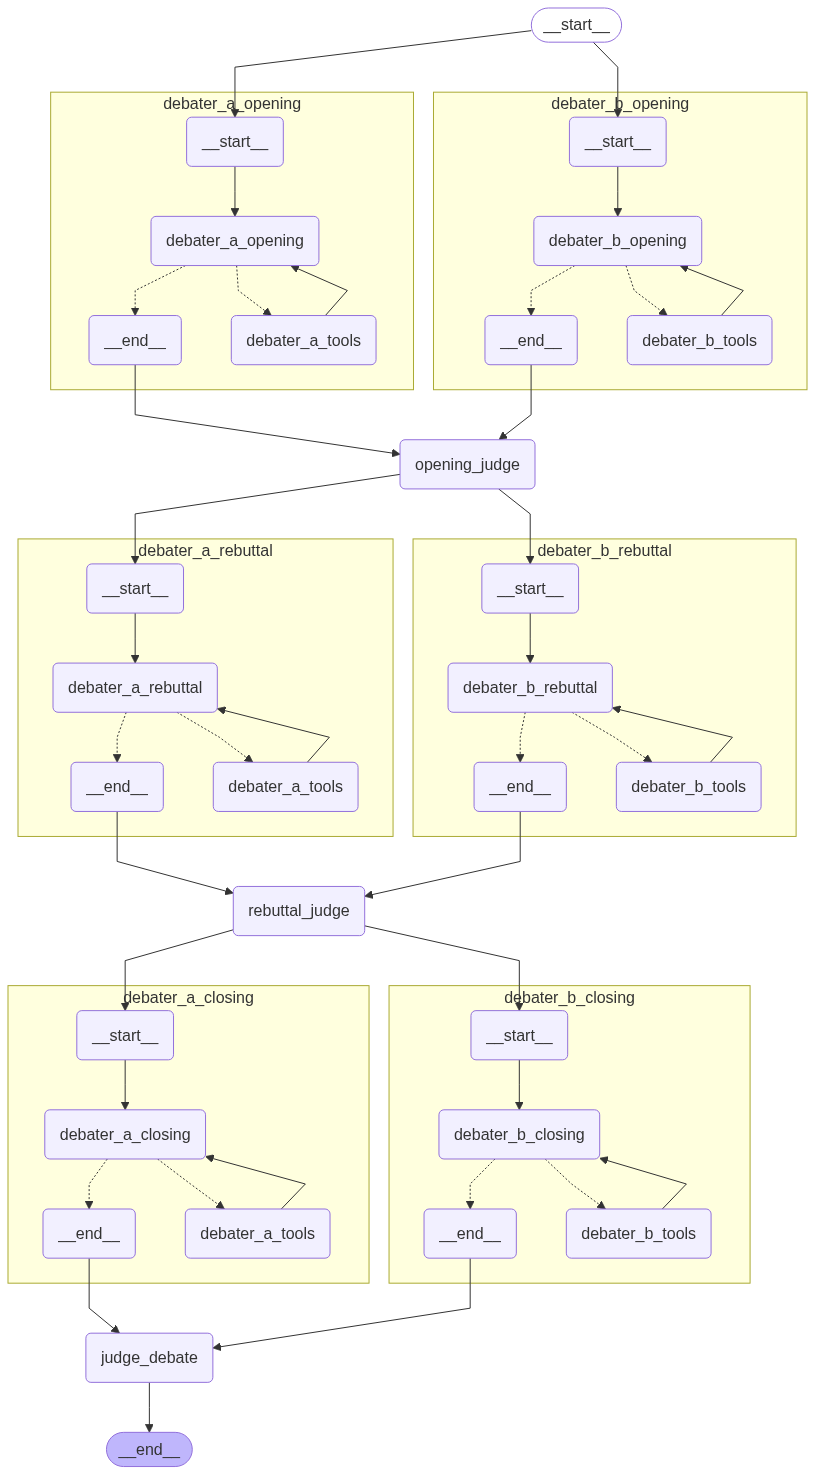

In [11]:
def get_last_valid_message(messages: List) -> str:
    for message in reversed(messages):
        if message.content != "":
            return message
    
    assert False, f"No valid message in {messages}"

def judge_opening(state: DebateState) -> DebateState:
    print("Judging the opening arguments")
    opening_a = get_last_valid_message(state["messages_a"])
    opening_b = get_last_valid_message(state["messages_b"])

    with open("./prompts.yaml", "r") as f:
        judge_prompt_template = yaml.safe_load(f)["opening_statement_judge"]
    
    judge_prompt = judge_prompt_template.format(
        issue=state["issue"],
        position_a=state["position_a"],
        position_b=state["position_b"],
        opening_a=opening_a,
        opening_b=opening_b,
    )
    judge_model_response = llm.invoke([judge_prompt])
    
    return {
        "opening_a": opening_a,
        "opening_b": opening_b,
        "opening_judge_results": judge_model_response
    }

def judge_rebuttal(state: DebateState) -> DebateState:
    print("Judging the rebuttal")
    rebuttal_a = get_last_valid_message(state["messages_a"])
    rebuttal_b = get_last_valid_message(state["messages_b"])

    with open("./prompts.yaml", "r") as f:
        judge_prompt_template = yaml.safe_load(f)["rebuttal_judge"]
    
    judge_prompt = judge_prompt_template.format(
        issue=state["issue"],
        position_a=state["position_a"],
        position_b=state["position_b"],
        opening_a=state["opening_a"],
        opening_b=state["opening_b"],
        rebuttal_a=rebuttal_a,
        rebuttal_b=rebuttal_b
    )
    judge_model_response = llm.invoke([judge_prompt])
    
    return {
        "rebuttal_a": rebuttal_a,
        "rebuttal_b": rebuttal_b,
        "rebuttal_judge_results": judge_model_response
    }

def judge_debate(state: DebateState) -> DebateState:
    print("Judging the whole debate")
    closing_a = get_last_valid_message(state["messages_a"])
    closing_b = get_last_valid_message(state["messages_b"])

    with open("./prompts.yaml", "r") as f:
        judge_prompt_template = yaml.safe_load(f)["judge_debate"]
    
    judge_prompt = judge_prompt_template.format(
        issue=state["issue"],
        position_a=state["position_a"],
        position_b=state["position_b"],
        opening_a=state["opening_a"],
        opening_b=state["opening_b"],
        opening_judge_results=state["opening_judge_results"],
        rebuttal_a=state["rebuttal_a"],
        rebuttal_b=state["rebuttal_b"],
        rebuttal_judge_results=state["rebuttal_judge_results"],
        closing_a=closing_a,
        closing_b=closing_b
    )
    judge_model_response = llm.invoke([judge_prompt])

    return {
        "closing_a": closing_a,
        "closing_b": closing_b,
        "final_judge_results": judge_model_response
    }


builder = StateGraph(DebateState)
builder.add_node("debater_a_opening", debater_a_opening_subgraph)
builder.add_node("debater_b_opening", debater_b_opening_subgraph)
builder.add_node("opening_judge", judge_opening)
builder.add_node("debater_a_rebuttal", debater_a_rebuttal_subgraph)
builder.add_node("debater_b_rebuttal", debater_b_rebuttal_subgraph)
builder.add_node("rebuttal_judge", judge_rebuttal)
builder.add_node("debater_a_closing", debater_a_closing_subgraph)
builder.add_node("debater_b_closing", debater_b_closing_subgraph)
builder.add_node("judge_debate", judge_debate)

builder.add_edge(START, "debater_a_opening")
builder.add_edge(START, "debater_b_opening")
builder.add_edge("debater_a_opening", "opening_judge")
builder.add_edge("debater_b_opening", "opening_judge")
builder.add_edge("opening_judge", "debater_a_rebuttal")
builder.add_edge("opening_judge", "debater_b_rebuttal")
builder.add_edge("debater_a_rebuttal", "rebuttal_judge")
builder.add_edge("debater_b_rebuttal", "rebuttal_judge")
builder.add_edge("rebuttal_judge", "debater_a_closing")
builder.add_edge("rebuttal_judge", "debater_b_closing")
builder.add_edge("debater_a_closing", "judge_debate")
builder.add_edge("debater_b_closing", "judge_debate")
builder.add_edge("judge_debate", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
ukraine_input = {
    "issue": "Should Western countries continue providing military aid to Ukraine in its conflict with Russia?",
    "position_a": "Western countries should continue providing military aid to Ukraine in its conflict with Russia.",
    "position_b": "Western countries should not continue providing military aid to Ukraine in its conflict with Russia.",
}

cereal_soup_input = {
    "issue": "Is cereal a soup?",
    "position_a": "Cereal should be considered a soup",
    "position_b": "Cereal should not be considered a soup",
}

wheels_vs_doors_input = {
    "issue": "Are there more wheels or doors in the world?",
    "position_a": "There are more wheels than doors in the world.",
    "position_b": "There are more doors than wheels in the world.",
}

result = graph.invoke(wheels_vs_doors_input)

In debater_llm, side = a, prompt = opening_statement
In debater_llm, side = b, prompt = opening_statement
Result for side = b, prompt_name = opening_statement is content='' additional_kwargs={'function_call': {'name': 'web_search', 'arguments': '{"query": "are there more wheels or doors in the world common arguments"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--e1e492e2-d5b4-409d-8833-3d9b88d57d0f-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'are there more wheels or doors in the world common arguments'}, 'id': '783389be-ff6b-4a8e-bcdf-54b3f8c811c0', 'type': 'tool_call'}] usage_metadata={'input_tokens': 567, 'output_tokens': 516, 'total_tokens': 1083, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 491}}
Doing a web search for are there more wheels or doors in the world common arguments
Result for side = a, prompt_n

In [14]:
export_debate_state(result, "debate_dumps/wheels_vs_doors.txt")